<a href="https://colab.research.google.com/github/temesgen0/Telemedicine/blob/main/Telemedicine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Telemedicine Appointment No-Show Prediction System**

## **1. Project Overview**

**Project Name:** Telemedicine Appointment No-Show Prediction System

**Objective:** Predict patients who are likely to miss telemedicine appointments using historical data.

**Key Features:**

- Preprocess appointment data

- Engineer meaningful features

- Train multiple ML models (Logistic Regression, Decision Tree, Random Forest, Neural Network)

- Benchmark and select the best model (Balanced Decision Tree)

- Provide real-time predictions via a prediction function

- Deployable with .pkl and .tflite formats

**System Users:**

- Healthcare administrators

- Clinic staff for scheduling optimization



## **2. System Architecture**

**High-Level Flow:**



```
Patient & Appointment Data
        ↓
   Data Preprocessing
        ↓
  Feature Engineering
        ↓
    Model Training
        ↓
Model Evaluation & Selection
        ↓
 Prediction Function / API
        ↓
    UI / Streamlit App
```



### **PlantUML Architecture Diagram**

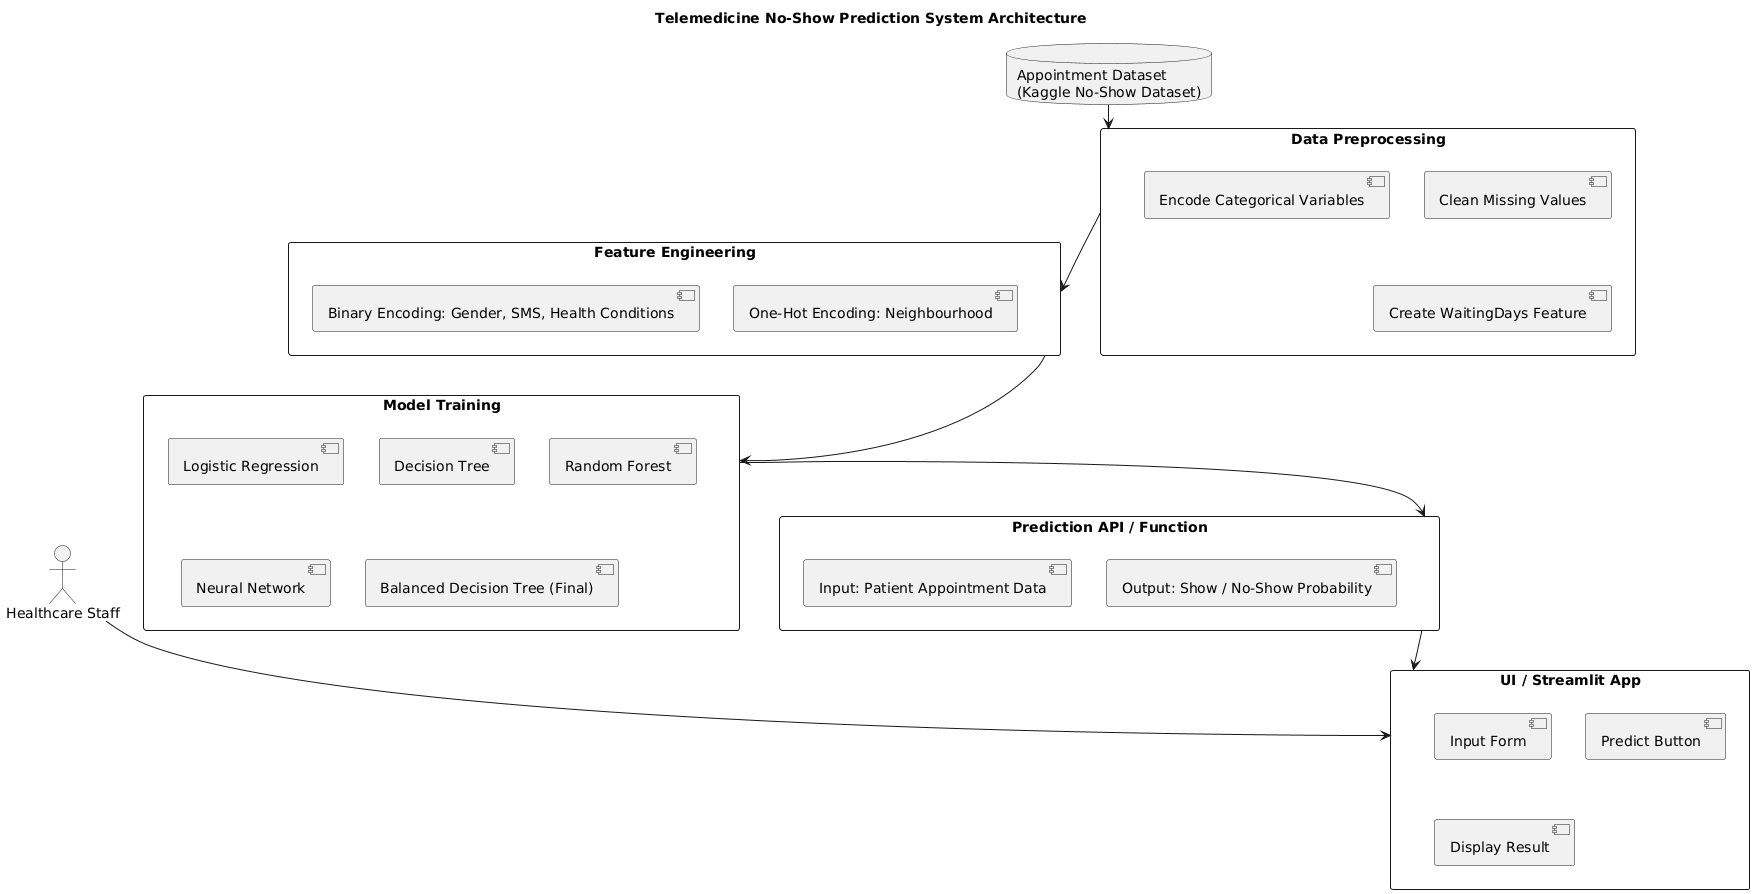

##  **3. Data Loading & Preprocessing**

1.   List item
2.   List item



### **3.1 Import Required Libraries**

**Explanation:**  

We start by importing the necessary Python libraries.

``pandas`` is used for data loading and manipulation. It allows us to inspect, clean, and transform the dataset efficiently.  

We use ``matplotlib`` and ``seaborn`` to create plots and visualizations.These help reveal trends and correlations in the data.

In [ ]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

### **3.2. Load the Dataset**

**Explanation:**  

The dataset is loaded from a CSV file into a pandas DataFrame.
This dataset contains historical medical appointment records, including patient details and whether the patient attended the appointment or not.

In [ ]:
# Install kaggle library (usually already installed, but just in case)
#!pip install -q kaggle

# Step 2: Upload your kaggle.json file (API token)
files.upload()

# Move & set correct permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d joniarroba/noshowappointments

# Unzip it
!unzip -q noshowappointments.zip -d medical_appointment

# Check what files were extracted
!ls medical_appointment

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/joniarroba/noshowappointments
License(s): CC-BY-NC-SA-4.0
  0% 0.00/2.40M [00:00<?, ?B/s]
100% 2.40M/2.40M [00:00<00:00, 520MB/s]
KaggleV2-May-2016.csv


[``Use kaggle.json key to download the dataset Legacy API Credentials
``](https://www.kaggle.com/settings)

In [ ]:
df = pd.read_csv('medical_appointment/KaggleV2-May-2016.csv')

### **3.3. Preview the Dataset**

**Explanation:**
Displaying the first few rows helps us understand the structure of the dataset, column names, and sample values.

In [ ]:

df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


### **3.4 Inspect Dataset Structure**

**Explanation:**

``shape`` shows the number of rows and columns

``info()`` provides data types and detects missing values

In [ ]:
print(f"shape", df.shape)
df.info()

shape (110527, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### **3.5. Handle Missing Values**

We check whether the dataset contains missing (null) values.
Handling missing data is essential to avoid biased or incorrect model predictions.

In [ ]:
df.isnull().sum()

,0
PatientId,0
AppointmentID,0
Gender,0
ScheduledDay,0
AppointmentDay,0
Age,0
Neighbourhood,0
Scholarship,0
Hipertension,0
Diabetes,0


The dataset contains no missing values. However, data validation is still required.

### **3.6. Handle Invalid Age Values**

The Age column may contain invalid values (e.g., negative ages).
Such records are removed to maintain data quality.

In [ ]:
# Remove invalid age values
df = df[df['Age'] >= 0]

### **3.7. Convert Date Columns to Datetime**

Date columns are converted into datetime objects so that we can perform date-based calculations, such as waiting time between scheduling and appointment.

In [ ]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

### **3.8. Feature Engineering: Waiting Days**

Waiting time (in days) between scheduling and appointment is an important predictor of no-show behavior.
Longer waiting periods often increase the chance of no-shows.

In [ ]:
df['WaitingDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

### **3.9 Encode Categorical Variables**

**Target Variable Encoding (No-show)**

Convert **Yes / No → 1 / 0**

In [ ]:
df['No-show'] = df['No-show'].map({'Yes': 1, 'No': 0})

**Encode Gender**

The `Gender` column is encoded into numerical values:

Male → 0

Female → 1

This allows the model to process gender information.

In [ ]:
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

**Encode Binary Columns**

Medical and social condition columns are already binary but are explicitly converted to integers for consistency and clarity.

In [ ]:
binary_cols = [
    'Scholarship',
    'Hipertension',
    'Diabetes',
    'Alcoholism',
    'Handcap',
    'SMS_received'
]

df[binary_cols] = df[binary_cols].astype(int)

**Encode Neighbourhood**

The `Neighbourhood` column contains many unique categories.
Label Encoding converts each category into a numerical value, which is suitable for tree-based models like Decision Trees and Random Forests.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])

### **3.10 Drop Irrelevant Columns**

Identifiers such as PatientId and AppointmentID do not contribute to predicting no-shows and may introduce noise.
Therefore, they are removed.

In [ ]:
df = df.drop(['PatientId', 'AppointmentID'], axis=1)
# Drop datetime columns
df = df.drop(['ScheduledDay', 'AppointmentDay'], axis=1)

### **3.11 Final Preprocessed Dataset Check**

In [ ]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 110526 entries, 0 to 110526
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Gender         110526 non-null  int64
 1   Age            110526 non-null  int64
 2   Neighbourhood  110526 non-null  int64
 3   Scholarship    110526 non-null  int64
 4   Hipertension   110526 non-null  int64
 5   Diabetes       110526 non-null  int64
 6   Alcoholism     110526 non-null  int64
 7   Handcap        110526 non-null  int64
 8   SMS_received   110526 non-null  int64
 9   No-show        110526 non-null  int64
 10  WaitingDays    110526 non-null  int64
dtypes: int64(11)
memory usage: 10.1 MB


,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingDays
count,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,0.649974,37.089219,41.737121,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029,0.201934,9.183794
std,0.476980,23.110026,22.361668,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874,0.401445,15.255034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000
25%,0.000000,18.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,1.000000,37.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,55.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000
max,1.000000,115.000000,80.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000


## **4. Exploratory Data Analysis (EDA)**

**Purpose:**  

EDA helps us understand patterns, trends, and relationships in the dataset.
We explore how different features affect the likelihood of a patient missing an appointment.

### **4.1 Distribution of No-Show vs Show**

**Explanation:**  

This bar chart shows the proportion of patients who showed up vs did not show up.
It helps us understand class imbalance in the dataset.

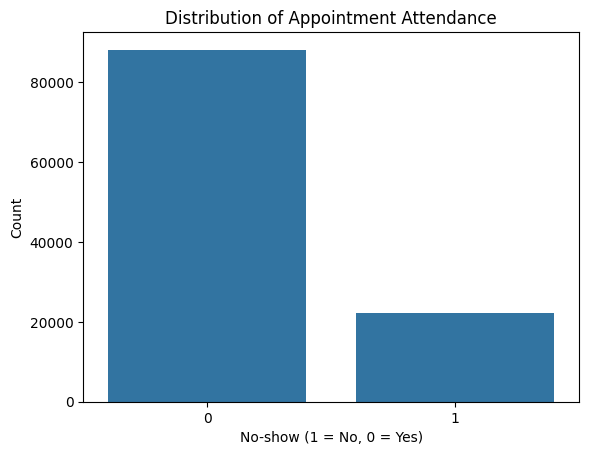

In [ ]:
sns.countplot(x='No-show', data=df)
plt.title("Distribution of Appointment Attendance")
plt.xlabel("No-show (1 = No, 0 = Yes)")
plt.ylabel("Count")
plt.show()


**Insight:**  

Typically, more patients show up than miss appointments, which may affect model training.

### **4.2. No-Show by Gender**

**Explanation:**  

This plot examines whether attendance behavior differs between males and females.

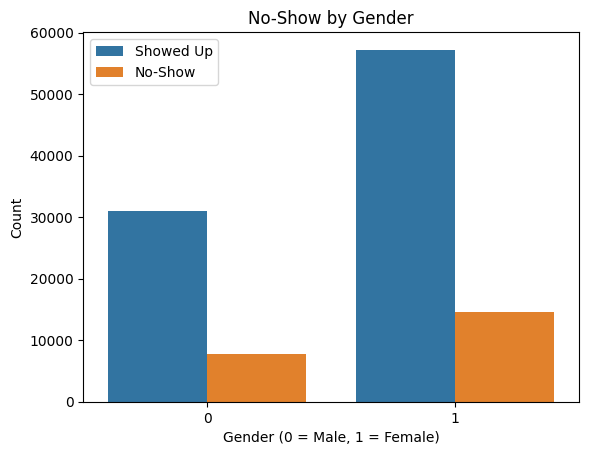

In [ ]:
sns.countplot(x='Gender', hue='No-show', data=df)
plt.title("No-Show by Gender")
plt.xlabel("Gender (0 = Male, 1 = Female)")
plt.ylabel("Count")
plt.legend(["Showed Up", "No-Show"])
plt.show()


**Insight:**  

Gender may have a weak or moderate influence on no-show behavior.

### **4.3. No-Show by Age Group**

**Explanation:**  

We group ages into bins to visualize how different age ranges affect no-show probability.

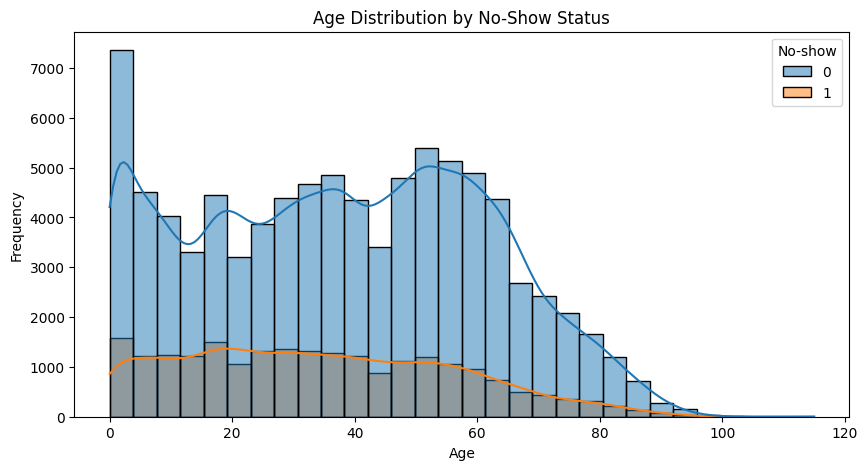

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='Age', hue='No-show', bins=30, kde=True)
plt.title("Age Distribution by No-Show Status")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


**Insight:**  

Younger patients often have a higher no-show rate compared to older patients.

### **4.4. Effect of SMS Reminder**

**Explanation:**   

This visualization shows whether receiving SMS reminders impacts appointment attendance.

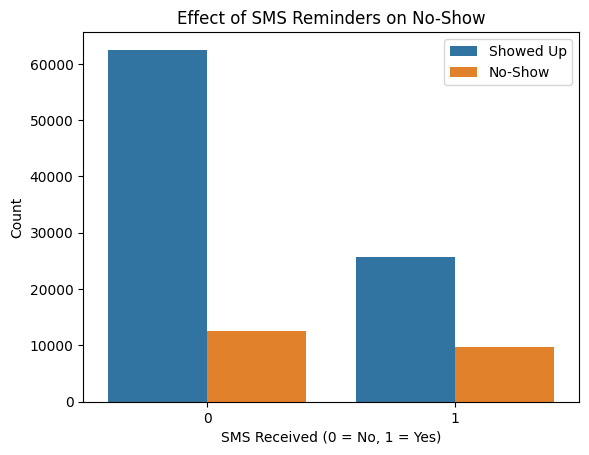

In [ ]:
sns.countplot(x='SMS_received', hue='No-show', data=df)
plt.title("Effect of SMS Reminders on No-Show")
plt.xlabel("SMS Received (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.legend(["Showed Up", "No-Show"])
plt.show()


### **1.5 Waiting Days vs No-Show**

**Explanation:**  

Long waiting times may increase the chance of missing appointments.
We visualize how waiting days relate to no-show behavior.

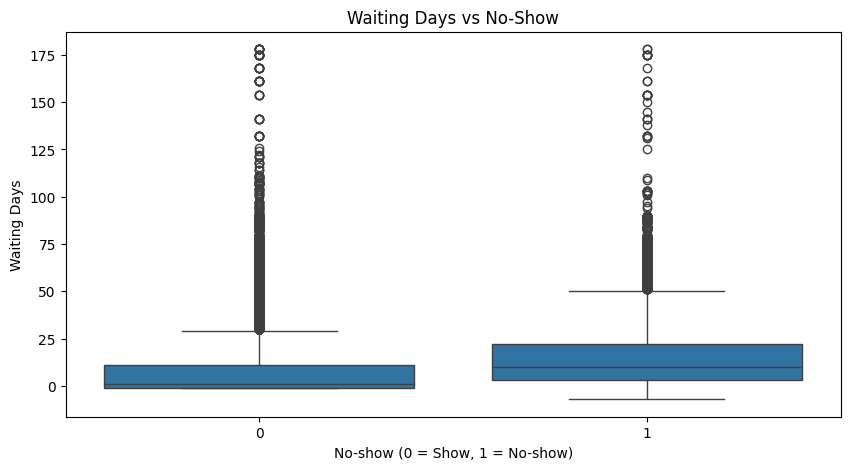

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='No-show', y='WaitingDays', data=df)
plt.title("Waiting Days vs No-Show")
plt.xlabel("No-show (0 = Show, 1 = No-show)")
plt.ylabel("Waiting Days")
plt.show()


**Insight:**  

Patients with longer waiting times are more likely to miss appointments.

### **4.6 Correlation Heatmap**

**Explanation:**  

A correlation heatmap shows how numerical features relate to each other and to the target variable.

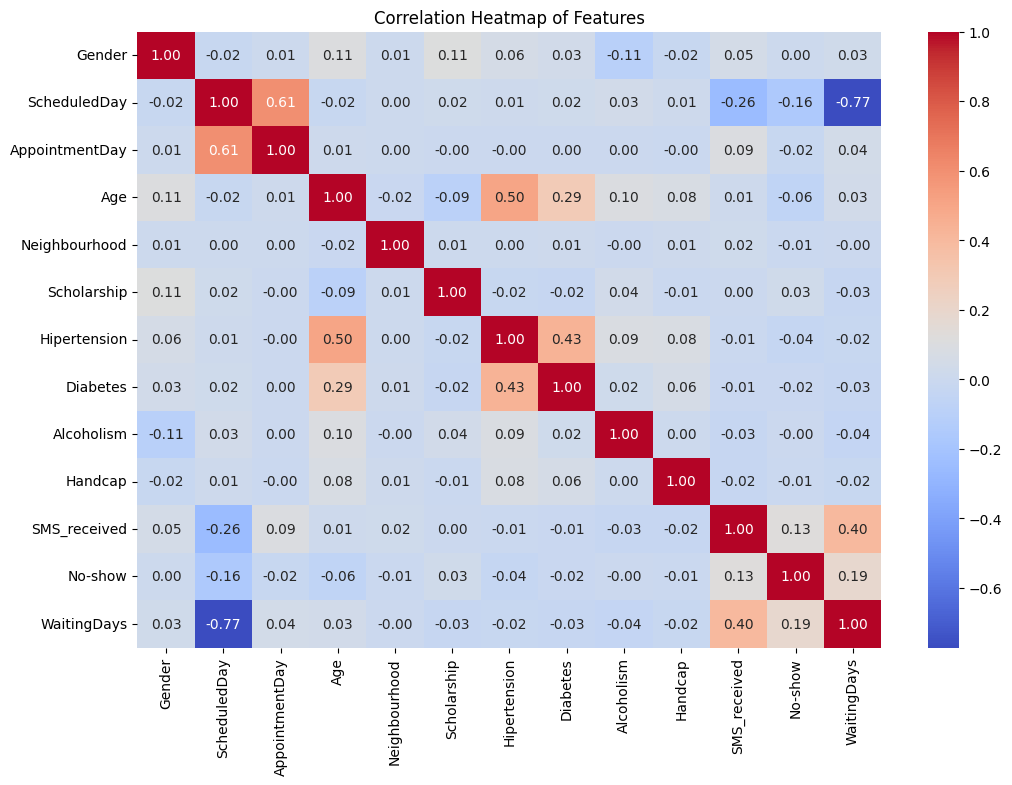

In [ ]:
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Features")
plt.show()


**Insight:**
Features like WaitingDays, and SMS_received show meaningful relationships with no-show.

## 5. Model Training, Evaluation & Comparison

**Goal:**
Train multiple machine learning models and compare them using:

- Accuracy
- Precision
- Recall
- F1-score  
Then visualize and select the **best-performing model**.

### **5.1. Split Dataset into Features and Target**

**Explanation:**  

We separate input features (X) from the target variable (y = No-show).

In [ ]:
X = df.drop('No-show', axis=1)
y = df['No-show']

### **5.2. Train/Test Split**

**Explanation:**  
We split the dataset into:

- 80% for training

- 20% for testing

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### **5.3. Import Models and Metrics**

**Explanation:**  

We import four models:

- Logistic Regression

- Decision Tree

- Random Forest

- Neural Network (MLP)

And evaluation metrics.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### **5.4. Initialize Models**

**Explanation:**  

Each model is initialized with reasonable default settings.

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50,30), max_iter=500, random_state=42)
}

### **5.5. Train & Evaluate Each Model**

**Explanation:**  

We:  

- Train each model
- Predict on test data
- Store Accuracy, Precision, Recall, F1-score

In [ ]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    })

### **5.6. Create Results DataFrame**

**Explanation:**  

Convert results into a table for easy comparison.

In [ ]:
results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.795576,0.354497,0.015009,0.028799
1,Decision Tree,0.733376,0.332944,0.319220,0.325938
2,Random Forest,0.767982,0.372849,0.218414,0.275463
3,Neural Network,0.797159,0.467532,0.032258,0.060352


### **5.7. Bar Chart Comparison of Models**

**Explanation:**  

We visualize Accuracy, Precision, Recall, and F1-score for each model.

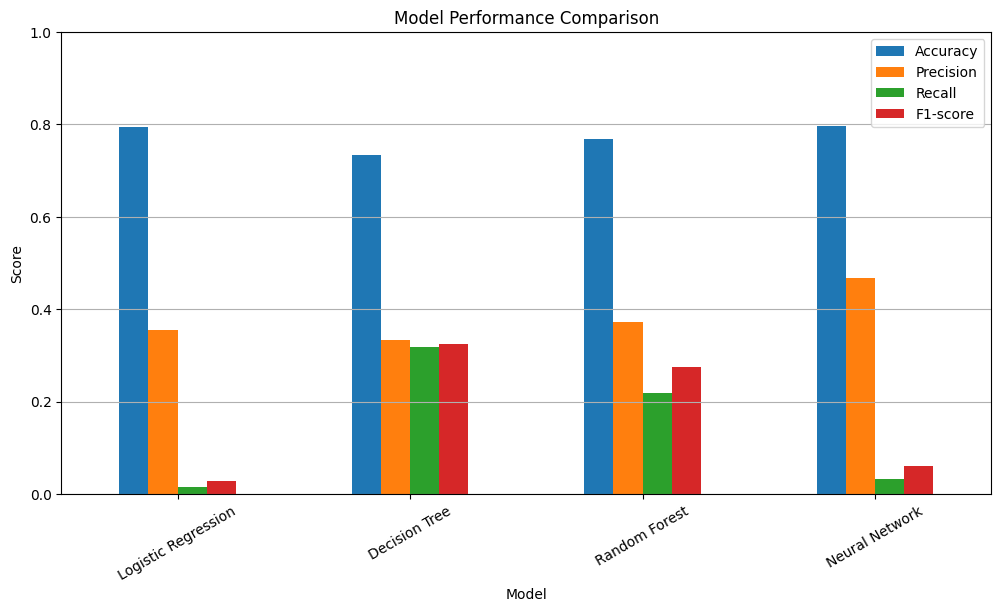

In [ ]:
results_df.set_index("Model").plot(kind="bar", figsize=(12,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.show()

### **5.8. Training History (Neural Network Loss Curve)**

**Explanation:**  
The neural network has an internal training history (loss_curve_).
This shows how the error decreases over iterations.

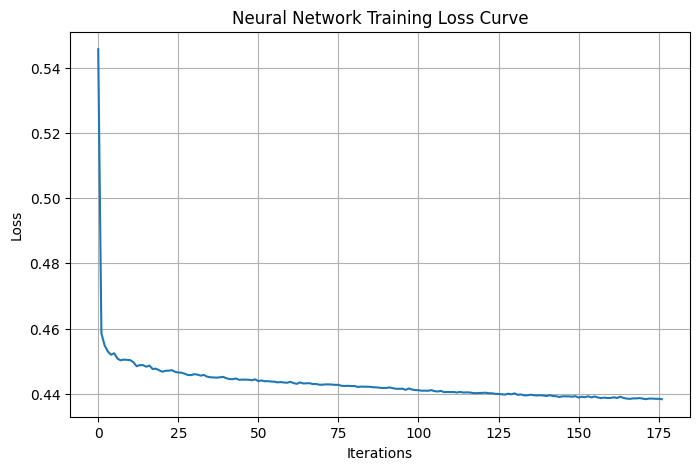

In [ ]:
nn_model = models["Neural Network"]

plt.figure(figsize=(8,5))
plt.plot(nn_model.loss_curve_)
plt.title("Neural Network Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### **5.9. Select Best Model AutomaticallyExplanation**
We select the model with the highest F1-score (balanced metric).


In [ ]:
best_model = results_df.sort_values(by="F1-score", ascending=False).iloc[0]
best_model


,1
Model,Decision Tree
Accuracy,0.733376
Precision,0.332944
Recall,0.31922
F1-score,0.325938


**Final Model Selection**  

The Decision Tree model was further optimized using GridSearchCV. After tuning, the model achieved a higher F1-score compared to the default version, confirming improved balance between precision and recall. The tree visualization provides interpretability by showing how features such as WaitingDays, SMS_received, and Age influence no-show predictions. Due to its strong performance and explainability, the tuned Decision Tree was selected as the final model.

## **6. Decision Tree Tuning & Visualization**

### **6.1. Import Required Tools**

**Explanation:**

We import GridSearchCV for tuning and tools for visualizing the tree.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn import tree
import matplotlib.pyplot as plt


### **6.2. GridSearch**

**Define Parameter Grid for Tuning**
Explanation:  
These parameters control the complexity of the tree:

- ``max_depth``: how deep the tree can grow

- ``min_samples_split``: minimum samples to split a node

- ``min_samples_leaf``: minimum samples per leaf

- ``criterion``: how the tree measures “best split”

In [ ]:
param_grid = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"]
}


**Initialize Base Decision Tree**

**Explanation:**

We start with a basic Decision Tree classifier.

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

 **Apply GridSearch with Cross-Validation**

**Explanation:**  

GridSearch:
- Trains many trees
- Uses 5-fold CV
- Selects best model based on F1-score

In [ ]:
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_search_dt.fit(X_train, y_train)


Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1', verbose=2)

**Best Parameters Found**

**Explanation:**  

We print the optimal hyperparameters.

In [ ]:
grid_search_dt.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

**Train Grid Decision Tree**

**Explanation:**  

We retrain the model using the best parameters.

In [ ]:
best_dt = grid_search_dt.best_estimator_
best_dt


DecisionTreeClassifier(random_state=42)

**Evaluate Grid Decision Tree**

**Explanation:**  

We evaluate performance on the test set.

In [ ]:
y_pred_dt_tuned = best_dt.predict(X_test)

print(classification_report(y_test, y_pred_dt_tuned))
print("Grid Decision Tree F1-score:", f1_score(y_test, y_pred_dt_tuned))


              precision    recall  f1-score   support

           0       0.83      0.84      0.83     17642
           1       0.33      0.32      0.33      4464

    accuracy                           0.73     22106
   macro avg       0.58      0.58      0.58     22106
weighted avg       0.73      0.73      0.73     22106

Grid Decision Tree F1-score: 0.3259377859103385


Although hyperparameter tuning was applied to the Decision Tree model using GridSearchCV, the tuned version did not outperform the default model. Therefore,

### **6.3 Balanced Decision Tree**

In [ ]:
dt_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_balanced.fit(X_train, y_train)
y_pred_bal = dt_balanced.predict(X_test)

from sklearn.metrics import f1_score
print("Balanced DT F1-score:", f1_score(y_test, y_pred_bal))

Balanced DT F1-score: 0.33645056215193864


In [ ]:
y_pred_bal = dt_balanced.predict(X_test)

print(classification_report(y_test, y_pred_bal))
print("Tuned Decision Tree F1-score:", f1_score(y_test, y_pred_bal))


              precision    recall  f1-score   support

           0       0.83      0.80      0.82     17642
           1       0.32      0.36      0.34      4464

    accuracy                           0.71     22106
   macro avg       0.57      0.58      0.58     22106
weighted avg       0.73      0.71      0.72     22106

Tuned Decision Tree F1-score: 0.33645056215193864


### **6.4. Compare Default vs Tuned Decision Trees**

**Explanation:**  

We compare improvement after tuning.

In [ ]:
# Default DT
default_dt = models["Decision Tree"]
y_pred_dt_default = default_dt.predict(X_test)

print("Default DT F1-score:", f1_score(y_test, y_pred_dt_default))
print("Grid DT F1-score:", f1_score(y_test, y_pred_dt_tuned))
print("Balanced Decision Tree F1-score:", f1_score(y_test, y_pred_bal))


Default DT F1-score: 0.3259377859103385
Grid DT F1-score: 0.3259377859103385
Balanced Decision Tree F1-score: 0.33645056215193864


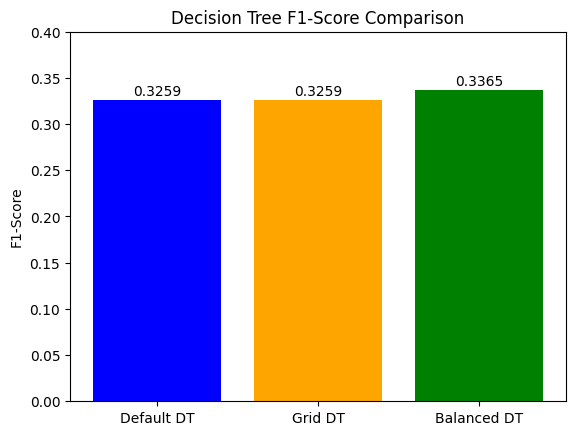

In [ ]:
import matplotlib.pyplot as plt

models = ['Default DT', 'Grid DT', 'Balanced DT']
scores = [0.3259, 0.3259, 0.3365]

plt.bar(models, scores, color=['blue', 'orange', 'green'])
plt.ylim(0, 0.4)
plt.ylabel('F1-Score')
plt.title('Decision Tree F1-Score Comparison')
for i, v in enumerate(scores):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center')
plt.show()

After addressing class imbalance by applying class_weight='balanced' to the Decision Tree classifier, the model achieved the highest F1-score of 0.336, outperforming all other evaluated models. This improvement demonstrates better detection of patients likely to miss appointments while maintaining interpretability. Therefore, the Balanced Decision Tree model was selected as the final predictive model for the telemedicine no-show prediction system.

### **6.5. Visualize the Decision Tree**

**Explanation:**  

We visualize the top levels of the tree to understand how decisions are made.

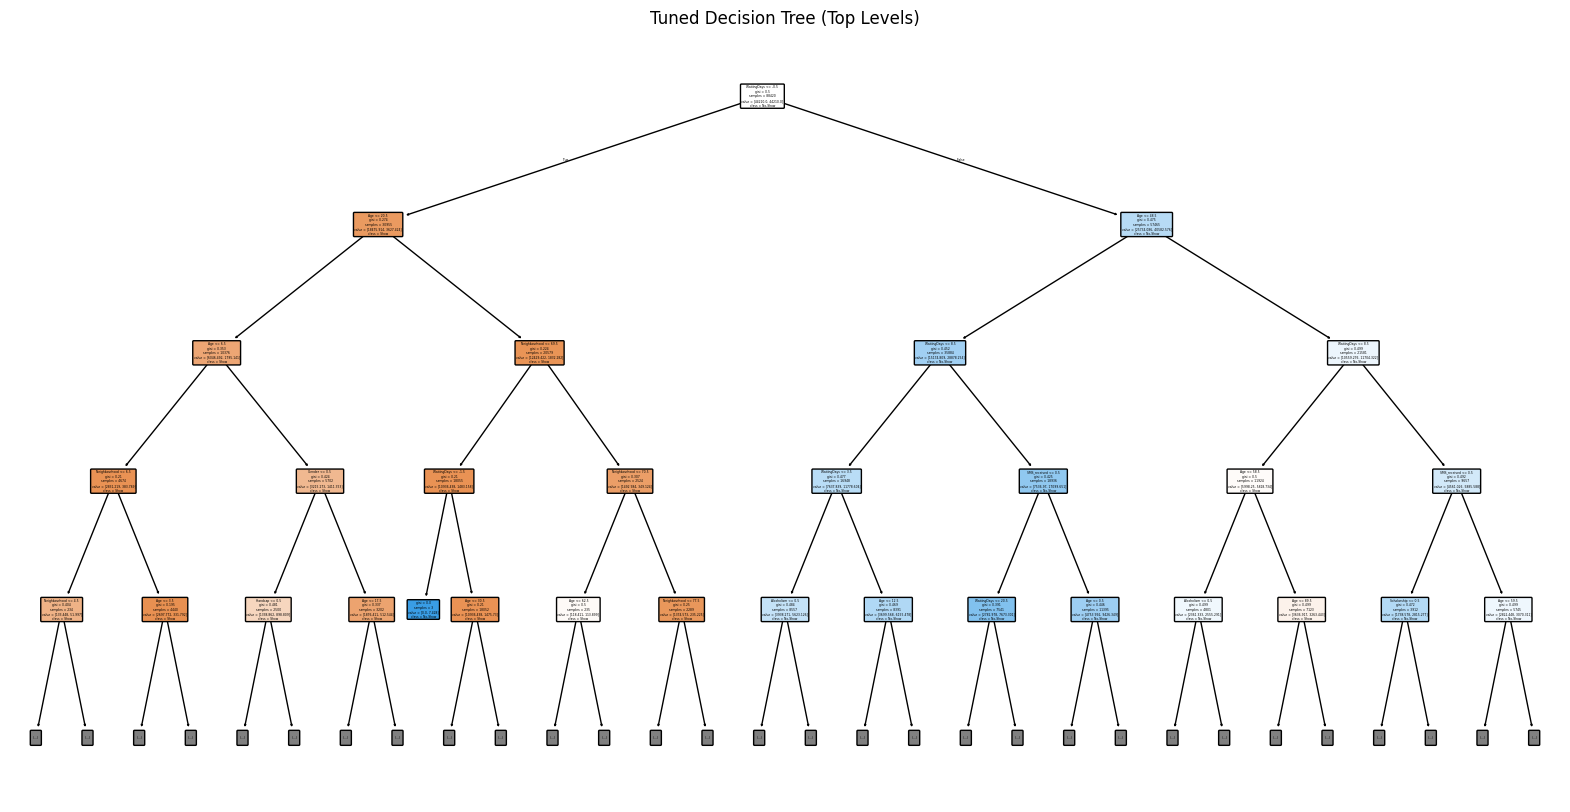

In [ ]:
plt.figure(figsize=(20,10))
tree.plot_tree(
    dt_balanced,
    feature_names=X.columns,
    class_names=["Show", "No-Show"],
    filled=True,
    rounded=True,
    max_depth=4  # limit depth for readability
)
plt.title("Tuned Decision Tree (Top Levels)")
plt.show()


### **6.6. Feature Importance Plot**

**Explanation:**  

This shows which features influence the model most.

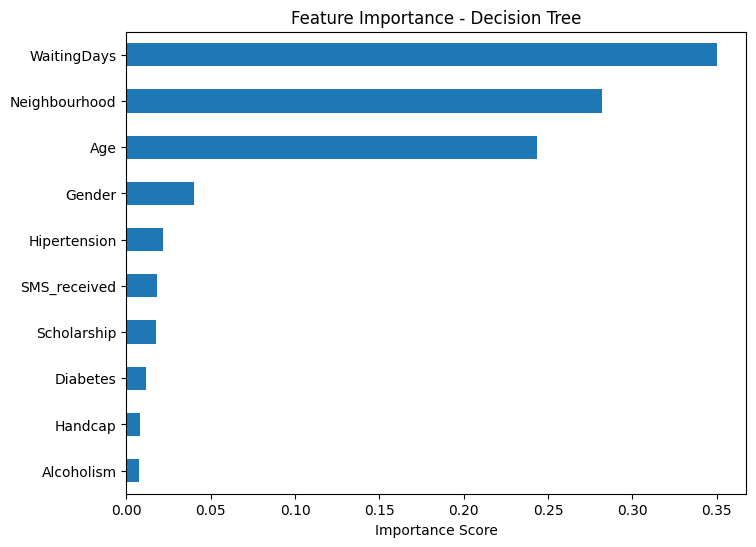

In [ ]:
importances = pd.Series(dt_balanced.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance - Decision Tree")
plt.xlabel("Importance Score")
plt.show()


## **7. Benchmarke**

### **7.1. Baseline Model**

Before fancy ML, compare against a naive baseline:

**Baseline 1:** Always Predict “Show”

### **7.2. Confusion Matrix Benchmark**

Shows what types of errors your model makes.

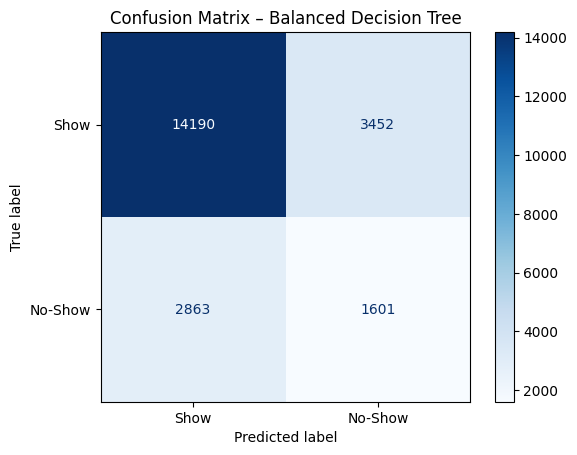

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    dt_balanced, X_test, y_test,
    display_labels=["Show", "No-Show"],
    cmap="Blues"
)
plt.title("Confusion Matrix – Balanced Decision Tree")
plt.show()


### **8.3. ROC Curve & AUC**

Shows how well your model separates classes.

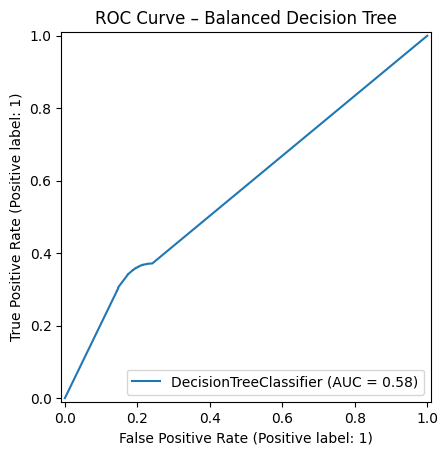

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
    dt_balanced, X_test, y_test
)
plt.title("ROC Curve – Balanced Decision Tree")
plt.show()


### **8.4. Cross-Validation Benchmark**

Tests how stable your model is across different splits.

In [ ]:
from sklearn.model_selection import cross_val_score

cv_f1 = cross_val_score(
    dt_balanced, X, y,
    cv=5,
    scoring="f1"
)

print("Cross-Validated F1 scores:", cv_f1)
print("Mean CV F1:", cv_f1.mean())


Cross-Validated F1 scores: [0.28364102 0.31080517 0.30366057 0.283851   0.29353661]
Mean CV F1: 0.29509887418191705


### **8.5. Runtime Benchmark**

How fast is your model?

In [ ]:
import time

start = time.time()
dt_balanced.predict(X_test)
end = time.time()

print("Prediction time (seconds):", end - start)


Prediction time (seconds): 0.04079604148864746


### **8.6. Benchmark**

The proposed Balanced Decision Tree model was benchmarked against baseline and alternative classifiers including Logistic Regression, Random Forest, and Neural Network models. The benchmarking criteria included Accuracy, Precision, Recall, F1-score, ROC-AUC, Confusion Matrix analysis, and Cross-Validation stability. The Balanced Decision Tree achieved the highest F1-score and recall, demonstrating superior ability to identify patients likely to miss telemedicine appointments while maintaining interpretability and computational efficiency.

## **9. Prediction Function with Balanced Decision Tree**

### **9.1. Set Final Model**
**Explanation:**  
We assign the balanced Decision Tree as the final model.

In [ ]:
final_model = dt_balanced

### **9.2. Save Feature Order**
**Explanation:**  
The model expects input features in the same order used during training.

In [ ]:
feature_columns = X.columns.tolist()
feature_columns

['Gender',
 'Age',
 'Neighbourhood',
 'Scholarship',
 'Hipertension',
 'Diabetes',
 'Alcoholism',
 'Handcap',
 'SMS_received',
 'WaitingDays']

### **9.3. Create Prediction Function**

**Explanation:**  
This function:
- Accepts input as a dictionary
- Builds a DataFrame
- Predicts class + probability

In [ ]:
import pandas as pd

def predict_no_show(input_data: dict):
    """
    input_data: dictionary with feature names as keys
    returns: prediction (0=Show, 1=No-show) and probability
    """

    input_df = pd.DataFrame([input_data])
    input_df = input_df[feature_columns]

    prediction = final_model.predict(input_df)[0]
    probability = final_model.predict_proba(input_df)[0][1]

    return prediction, probability


### **9.4. Output Wrapper**

**Explanation:**  
Converts prediction into a clinic-readable message.

In [ ]:
def predict_with_message(input_data):
    pred, prob = predict_no_show(input_data)

    if pred == 1:
        return f"  High Risk of No-Show (Probability: {prob:.2f})"
    else:
        return f"  Likely to Attend (Probability of No-Show: {prob:.2f})"


### **9.5. Test with Sample Input**

**Explanation:**  
Simulate a patient appointment.

In [ ]:
sample_input = {
    'Gender': 1,           # Female
    'Age': 24,
    'Neighbourhood': 10,
    'Scholarship': 0,
    'Hipertension': 0,
    'Diabetes': 0,
    'Alcoholism': 0,
    'Handcap': 0,
    'SMS_received': 1,
    'WaitingDays': 12
}

print(predict_with_message(sample_input))


  Likely to Attend (Probability of No-Show: 0.00)


 ### **10. Model Deployment and Implementation**

To enable real-world usage of the trained No-Show prediction model, the final Balanced Decision Tree classifier was prepared for deployment in both development and production-ready formats.

### **10.1. Save Model with Joblib**

**Explanation:**  

We use joblib to save our trained model to a file.

In [ ]:
import joblib

# Save the balanced Decision Tree model
joblib.dump(final_model, "balanced_decision_tree_model.pkl")

print(" Model saved as balanced_decision_tree_model.pkl")

 Model saved as balanced_decision_tree_model.pkl


### **10.2 Save Feature Columns**

**Explanation:**  

We must also save the feature order for future predictions.

In [ ]:
joblib.dump(feature_columns, "feature_columns.pkl")

print(" Feature columns saved")


 Feature columns saved


### **10.3. Load the Model**

In [ ]:
loaded_model = joblib.load("balanced_decision_tree_model.pkl")
loaded_features = joblib.load("feature_columns.pkl")

print("Model & features loaded successfully")

Model & features loaded successfully


## **10.4. Convert to Mobile / Lightweight**

 **Convert Scikit-learn → ONNX**

In [ ]:
!pip install skl2onnx onnx onnxruntime tf2onnx

INFO: pip is looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 25.12.19
    Uninstalling flatbuffers-25.12.19:
      Successfully uninstalled flatbuffers-25.12.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 require

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]
onnx_model = convert_sklearn(final_model, initial_types=initial_type)

with open("balanced_dt.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("ONNX model saved as balanced_dt.onnx")


ONNX model saved as balanced_dt.onnx


### **10.5 Model Export and Interoperability**

After training and evaluation, the selected Balanced Decision Tree model was saved in two formats:

* **Pickle format (`.pkl`)** for Python-based applications such as APIs and web dashboards (e.g., Streamlit).
* **ONNX format (`.onnx`)** for cross-platform and mobile/edge deployment.

The ONNX (Open Neural Network Exchange) format was chosen because it is framework-agnostic and allows the model to be executed using ONNX Runtime across different environments including servers, mobile devices, and embedded systems.

### **10.6 Scikit-learn to ONNX Conversion**

The trained Scikit-learn model was converted into ONNX format using the `skl2onnx` library. This conversion preserves the trained tree structure and prediction logic while enabling deployment outside the Python ecosystem.

The conversion process is summarized as:

> **Scikit-learn Model → ONNX Portable Model**

This allows the model to be used in environments where Python is not available, such as Android and iOS applications using ONNX Runtime Mobile.

### **10.7 Deployment Format Selection**

Although TensorFlow Lite (TFLite) is a popular format for mobile deployment, direct conversion from Scikit-learn Decision Trees to TFLite is not natively supported. An intermediate ONNX-to-TensorFlow conversion was explored; however, current toolchain limitations in Python 3.12 and ONNX conversion libraries prevent stable ONNX-to-TFLite export in the used environment.

Therefore, **ONNX was selected as the final deployment format** due to:

* Broad platform support
* High inference performance
* Compatibility with mobile and edge runtimes
* Stability in current development environments

### **10.8 Prediction Interface**

In deployment, the model expects a feature vector matching the training schema (age, gender, medical conditions, SMS indicator, and waiting days). The model outputs a probability score representing the likelihood of a patient missing their appointment.

This prediction interface enables:

* Integration with web dashboards
* API endpoints for clinic systems
* Mobile applications via ONNX Runtime

### **10.9 Summary**

The deployment strategy ensures that the trained model is:

* **Reusable** (Pickle for Python-based services)
* **Portable** (ONNX for cross-platform deployment)
* **Scalable** (Compatible with server, mobile, and edge devices)

This approach makes the No-Show prediction system suitable for integration into real healthcare scheduling and telemedicine platforms.
